In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

In [64]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


#### CUDA 사용 및 EarlyStopping 설정

In [71]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


In [65]:
device = torch.device("mps")
early_stopping = EarlyStopping(patience = 5, verbose = True)

맥북 M2 MAX는 NVIDEA GPU를 사용하지 않아 CUDA 지원 안 함

#### 모델 저장

In [3]:
def saveModel():
    torch.save(model.state_dict(), 'model_ar2.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [4]:
# 하이퍼파라미터 설정
length = 24            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
hidden_size1 = 48      # 은닉층 1 크기
hidden_size2 = 24      # 은닉층 2 크기
hidden_size3 = 12      # 은닉층 3 크기
hidden_size4 = 6       # 은닉층 4 크기
learning_rate = 1e-6   # 학습률
epoch = 400
trainrun = 50          # 생성할 학습 데이터 시퀀스의 수 
testrun = 25           # 생성할 평가 데이터 시퀀스의 수 
validrun = 25          # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수
# phi1값을 0, 0.25, 0.4, 0.6, 0.8별로 생성
phi1 = np.array([np.repeat(0,8),
                 np.repeat(0.25,8),
                 np.repeat(0.4,8),
                 np.repeat(0.6,8),
                 np.repeat(0.8,8)])

phi1 = np.concatenate(phi1)

# phi2값을 0.1, 0.2, 0.3, 0.2, 0.1별로 생성
phi2 = np.array([np.repeat(0.1,8),
                 np.repeat(0.2,8),
                 np.repeat(0.3,8),
                 np.repeat(0.2,8),
                 np.repeat(0.1,8)])

phi2 = np.concatenate(phi2)

# 변화율 크기 (= 이상상태 포함 정도, psi)
psi1 = np.array([0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,])

# 공정의 수준 변화율 (delta)
de1 = np.array([0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,])

# 공정의 분산 변화율 (gamma)
ga = np.array([1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,])

#### 시계열 데이터 생성

In [6]:
np.random.seed(1)

# AR(2) 시계열 데이터 생성 함수
def ar2(phi1, phi2, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                                                        # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt((1 - phi2) / ((1 + phi2) * (1 - phi2 - phi1) * (1 - phi2 + phi1)))     # AR(2)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.array(np.repeat(0, length), dtype=np.float64)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(2, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i]     # AR(2)모델의 관리상태
            
        # psi 시점 이후의 데이터 생성 및 변동성 적용
        for i in range(psi,len(x)):                             # AR(2)모델의 이상상태
            e[i] = gamma * e[i]
            x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i] 
        for i in range(psi,len(x)):                             # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            x[i] = x[i] + delta*sigma
        
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i in range(len(phi1)):
        y[i]= ar2(phi1[i], phi2[i], de1[i], ga[i], psi1[i], length, run)

    return y


# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1), length)            # 생성된 훈련용 데이터를 적절한 형태로 재배열

# 레이블 생성 및 변형
train_y =  [np.repeat(0,trainrun),np.repeat(1,trainrun*7),      # 관리상태(1가지)는 0, 이상상태(7가지)는 1로 가정
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),]
train_y =  np.concatenate(train_y)
train_y = train_y.reshape(2000,1)                               # 최종 레이블 배열의 형태를 조정 (학습용 데이터 세트 2000개)

# PyTorch 텐서로 변환 및 장치 할당
# train_x = torch.FloatTensor(train_x).to(device)
# train_y = torch.FloatTensor(train_y).to(device)


# 평가용 시계열 데이터
# 데이터 생성 및 변형
test_x = totaldat(run = testrun, length = length)
test_x = test_x.reshape(testrun*len(phi1), length)

# 레이블 생성 및 변형
test_y = [np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),]
test_y = np.concatenate(test_y)
test_y = test_y.reshape(1000,1)                                 # 최종 레이블 배열의 형태를 조정 (평가용 데이터 세트 1000개)

# PyTorch 텐서로 변환 및 장치 할당
# test_x = torch.FloatTensor(test_x).to(device)
# test_y = torch.FloatTensor(test_y).to(device)


# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1), length)

# 레이블 생성 및 변형
valid_y = [np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),]
valid_y = np.concatenate(valid_y)
valid_y = valid_y.reshape(1000,1)                                 # 최종 레이블 배열의 형태를 조정 (검증용 데이터 세트 1000개)


# PyTorch 텐서로 변환 및 장치 할당
train_x = torch.FloatTensor(train_x).to(device)
train_y = torch.FloatTensor(train_y).to(device)
test_x = torch.FloatTensor(test_x).to(device)
test_y = torch.FloatTensor(test_y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)

# DataLoader 설정
trainset = TensorDataset(train_x, train_y)                        # 데이터와 레이블 쌍을 포함하는 데이터셋 생성
trainloader = DataLoader(trainset, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
testset = TensorDataset(test_x, test_y)
testloader = DataLoader(testset,shuffle = False)                  # 학습 및 검증에서는 데이터 순서 유지
validset = TensorDataset(valid_x, valid_y)
validloader = DataLoader(validset,shuffle = False)

#### 모델 구조

In [7]:
class NeuralNetwork(nn.Module):
    # 클래스 초기화
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(NeuralNetwork, self).__init__()
        self.device = device                                          
        self.hidden_size = hidden_size                                # RNN 모델의 은닉층 크기 
        self.num_layers = num_layers                                  # RNN 모델의 층 개수
        
        # 기본 RNN 레이어 생성
        self.rnn = nn.RNN(input_size= input_size,
                          hidden_size = hidden_size1,
                          num_layers = num_layers,
                          nonlinearity= "relu",                       # 활성화 함수로 relu를 사용
                          batch_first= True)                          # 입력 텐서의 첫 번째 차원이 배치 크기임을 나타냄
        
        # 완전 연결 레이어 (여러 레이어를 연속적으로 적용할 수 있게 하기 위해 nn.Sequential을 사용)
        self.fc = nn.Sequential(nn.Linear(hidden_size,hidden_size2),  # 선형 레이어
                                nn.GELU(),                            # GELU 활성화 함수
                                nn.Linear(hidden_size2,hidden_size3),
                                nn.GELU(),
                                nn.Linear(hidden_size3,hidden_size4),
                                nn.GELU(),
                                nn.Linear(hidden_size4,1),
                                nn.Sigmoid()                          # 시그모이드 활성화함수를 사용해 출력을 [0, 1] 범위로 조정
                                )

    # 순전파 (forward)
    def forward(self, x):
        # 초기 hidden state 설정
        h0 = torch.zeros(x.size()[0], self.hidden_size).to(device)    # 각 배치에 대한 초기 은닉층을 0으로 설정 (= RNN의 첫 번째 시점에서 이전 상태가 없음을 의미)
        
        # RNN 레이어 실행
        out, _ = self.rnn(x, h0)                                      # 입력 데이터 x와 초기 은닉층 h0를 RNN 층에 전달함. out: RNN의 마지막 레이어로부터 나온 output feature 를 반환 (hn: hidden state를 반환)
        
        # 데이터 재구성 및 완전 연결 레이어 실행
        out = out.reshape(out.shape[0], -1)                           # many to many 전략 : 시퀀스의 각 타임 스텝에 대응하는 출력 생성 
        out = self.fc(out)                                            # out을 재구성하여 모든 시간 단계의 출력을 하나의 벡터로 평탄화하고 완전 연결 레이어를 통해 최종 예측값을 계산
        
        return out


# 모델 초기화
model = NeuralNetwork(input_size = length, hidden_size = hidden_size1, num_layers = 1, device = device).to(device)

# Optimizer 설정
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# 손실 함수 설정
criterion = nn.MSELoss()

# 손실 기록을 위한 리스트 초기화
loss_ = []                                                            # 훈련 과정에서의 손실값 기록
n = len(trainloader)
valoss_ = []                                                          # 검증 과정에서의 손실값 기록
logger = {"train_loss": list(),
          "validation_loss": list()
         }

#### 학습 (Training)

epoch 1
train loss : 0.24202414896339178, validation loss : 0.24148082238435745
Validation loss decreased (inf --> 0.241481).  Saving model ...
epoch 2
train loss : 0.24156961768865587, validation loss : 0.24102311109751462
Validation loss decreased (0.241481 --> 0.241023).  Saving model ...
epoch 3
train loss : 0.2411162785689036, validation loss : 0.24056556374331314
Validation loss decreased (0.241023 --> 0.240566).  Saving model ...
epoch 4
train loss : 0.24066416997089982, validation loss : 0.24010986259579659
Validation loss decreased (0.240566 --> 0.240110).  Saving model ...
epoch 5
train loss : 0.24021227632462977, validation loss : 0.239654134452343
Validation loss decreased (0.240110 --> 0.239654).  Saving model ...
epoch 6
train loss : 0.23976031757767, validation loss : 0.23919798113405702
Validation loss decreased (0.239654 --> 0.239198).  Saving model ...
epoch 7
train loss : 0.2393075809116874, validation loss : 0.23874077544254915
Validation loss decreased (0.239198 --

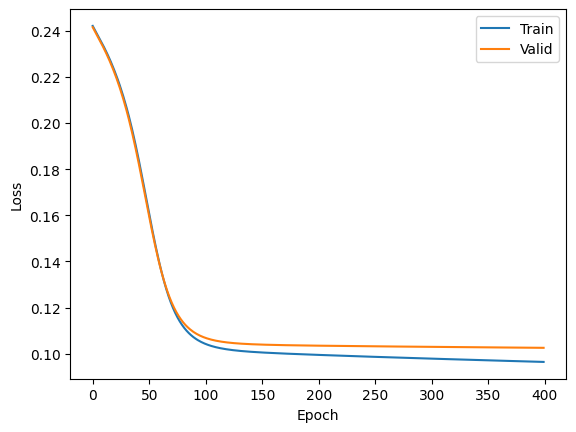

In [8]:
def training(epochs) :
    # epoch 별 훈련 및 검증 루프 (trainloader를 반복하여 모델 훈련시키고, validloader를 사용해 모델의 성능 검증)
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0
        total = 0

        # 훈련 과정
        for data in trainloader:
            model.train()
            inputs, outputs = data
            optimizer.zero_grad()                                                     # Optimizer Gradient를 0으로 초기화. 이는 각 미니배치마다 Gradient가 누적되는 것을 방지
            predicted_outputs = model(inputs)                                         # 모델을 사용하여 입력 데이터에 대한 예측값을 계산
            train_loss = criterion(predicted_outputs, outputs)                        # 계산된 예측값과 실제 레이블 간의 손실을 계산
            train_loss.backward()                                                     # 손실에 대한 역전파를 수행하여 Gradient를 계산
            optimizer.step()                                                          # 계산된 Gradient를 사용하여 모델 매개변수를 업데이트
            running_train_loss += train_loss.item()                                   # track the loss value
        loss_.append(running_train_loss / n)
        
        # 검증 과정
        with torch.no_grad():                                                         # Gradient 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 향상 
            model.eval()
            for data in validloader:
                inputs, outputs = data
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, outputs)

                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs,1)
                running_vall_loss += val_loss.item()
                total += outputs.size(0)
                val_loss_value = running_vall_loss/len(validloader)
        valoss_.append(val_loss_value)

        avgtrainloss = np.mean(loss_)
        avgvalidloss = np.mean(valoss_)
        print('epoch', epoch + 1)
        print(f'train loss : {avgtrainloss}, validation loss : {avgvalidloss}')
        
        # EarlyStopping
        early_stopping(avgvalidloss, model)                                           # 검증 손실을 기준으로 조기 종료 조건 확인
        if early_stopping.early_stop:                                                 # 조건 만족 시 조기 종료
            break

    # 모델 저장    
    saveModel()
training(epochs = epoch)


# 손실 시각화
plt.plot(loss_)
plt.plot(valoss_)
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 달민이 모델

In [69]:
model.load_state_dict(torch.load('model_ar2 (1).pt', map_location=torch.device('cpu')))

<All keys matched successfully>

#### 평가 (Evaluation)

In [9]:
def evaluation(dataloader):
  # 초기화
  estimated_outputs = torch.tensor([], dtype=torch.float64,device = device)  # 예측값을 저장하는 텐서.
  predictions = torch.tensor([], dtype=torch.float64, device = device) # 실제값을 저장하는 텐서.

  # 평가 모드 설정
  with torch.no_grad():
    model.eval()                                                       # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    # 데이터 로더를 통한 반복
    for data in dataloader:
        inputs, values = data
        outputs = model(inputs)

        # 예측값 및 실제값 저장
        estimated_outputs = torch.cat((estimated_outputs, outputs), 0)             # cat함수를 통해 예측값을 누적.
        predictions = torch.cat((predictions, values), 0)                        # cat함수를 통해 실제값을 누적.
  
  # CPU로 이동 및 NumPy 배열 변환
  estimated_outputs =estimated_outputs.to(device= "cpu")
  estimated_outputs = estimated_outputs.numpy()                                    # 넘파이 배열로 변경.
  predictions = predictions.to(device= "cpu")
  predictions = predictions.numpy()                                              # 넘파이 배열로 변경.
  
  # RMSE 계산
  rmse = np.sqrt(mean_squared_error(estimated_outputs, predictions))              # sklearn을 이용해 RMSE를 계산.

  return rmse,predictions,estimated_outputs

preds = []
for i in tqdm(range(1000)):
  test_rmse, predictions, estimated_outputs = evaluation(testloader)
  preds.append(estimated_outputs)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:06<00:00, 15.05it/s]


In [10]:
test_rmse

0.3210958122071271

In [11]:
predictions

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [12]:
estimated_outputs

array([[0.7821998 ],
       [0.83982658],
       [0.77403665],
       [0.62148333],
       [0.78675836],
       [0.75819427],
       [0.7998004 ],
       [0.69956738],
       [0.78173149],
       [0.76679116],
       [0.74079448],
       [0.66229481],
       [0.69019449],
       [0.75259888],
       [0.71311814],
       [0.76573884],
       [0.80625784],
       [0.87208831],
       [0.81293368],
       [0.77436054],
       [0.81803423],
       [0.72611529],
       [0.86476004],
       [0.78441077],
       [0.71765935],
       [0.87803841],
       [0.89394104],
       [0.77584332],
       [0.91251945],
       [0.77104455],
       [0.82289732],
       [0.91138232],
       [0.82247818],
       [0.92272192],
       [0.75296676],
       [0.73627496],
       [0.91939318],
       [0.7798512 ],
       [0.87305886],
       [0.888879  ],
       [0.82453054],
       [0.74014944],
       [0.81846642],
       [0.86826783],
       [0.90126306],
       [0.89990807],
       [0.67415071],
       [0.936

In [17]:
estimated_outputs.shape

(1000, 1)

#### 달민이 모델 평가

In [73]:
def evaluation(dataloader):
  # 초기화
  estimated_outputs = torch.tensor([], dtype=torch.float64,device = device)  # 예측값을 저장하는 텐서.
  predictions = torch.tensor([], dtype=torch.float64, device = device) # 실제값을 저장하는 텐서.

  # 평가 모드 설정
  with torch.no_grad():
    model.eval()                                                       # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    # 데이터 로더를 통한 반복
    for data in dataloader:
        inputs, values = data
        outputs = model(inputs)

        # 예측값 및 실제값 저장
        estimated_outputs = torch.cat((estimated_outputs, outputs), 0)             # cat함수를 통해 예측값을 누적.
        predictions = torch.cat((predictions, values), 0)                        # cat함수를 통해 실제값을 누적.
  
  # CPU로 이동 및 NumPy 배열 변환
  estimated_outputs =estimated_outputs.to(device= "cpu")
  estimated_outputs = estimated_outputs.numpy()                                    # 넘파이 배열로 변경.
  predictions = predictions.to(device= "cpu")
  predictions = predictions.numpy()                                              # 넘파이 배열로 변경.
  
  # RMSE 계산
  rmse = np.sqrt(mean_squared_error(estimated_outputs, predictions))              # sklearn을 이용해 RMSE를 계산.

  return rmse,predictions,estimated_outputs

preds = []
for i in tqdm(range(1000)):
  test_rmse, predictions, estimated_outputs = evaluation(testloader)
  preds.append(estimated_outputs)

100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s]


#### 실제값과 예측값 시각화

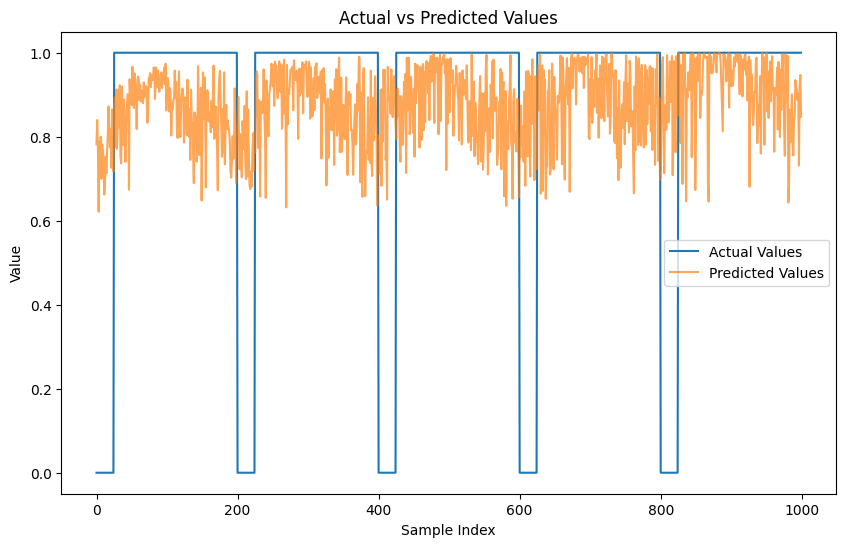

In [13]:
# 실제 값과 예측값을 시각화하는 코드
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(predictions, label='Actual Values')  # 실제 값 그래프
plt.plot(estimated_outputs, label='Predicted Values', alpha=0.7)  # 예측 값 그래프, 투명도를 주어 구분하기 쉽게 함
plt.title('Actual vs Predicted Values')  # 그래프 제목
plt.xlabel('Sample Index')  # x축 라벨
plt.ylabel('Value')  # y축 라벨
plt.legend()  # 범례 표시
plt.show()  # 그래프 표시

#### 실제값과 예측값 시각화 달민 모델

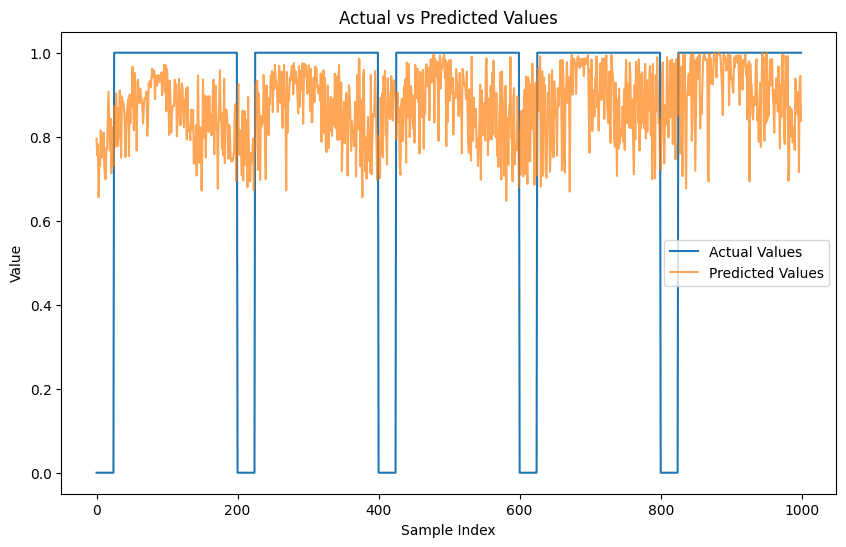

In [74]:
# 실제 값과 예측값을 시각화하는 코드
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(predictions, label='Actual Values')  # 실제 값 그래프
plt.plot(estimated_outputs, label='Predicted Values', alpha=0.7)  # 예측 값 그래프, 투명도를 주어 구분하기 쉽게 함
plt.title('Actual vs Predicted Values')  # 그래프 제목
plt.xlabel('Sample Index')  # x축 라벨
plt.ylabel('Value')  # y축 라벨
plt.legend()  # 범례 표시
plt.show()  # 그래프 표시

#### ARL0 구하기

In [75]:
np.random.seed(1)

l = 24

def ar2gen(phi1, phi2, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt((1 - phi2) / ((1 + phi2) * (1 - phi2 - phi1) * (1 - phi2 + phi1)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(2, psi):
        x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [76]:
def arl(phi1, phi2, delta, gamma, run, length, cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = ar2gen(phi1, phi2, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)

                if output[0] > cl :

                    a = np.array([j + 1])
                    #print(output)
                    break
                elif j == len(x):
                    a = len(x)

            #print(a)
            rl = np.append(rl,a)

    arl = np.mean(rl)
    #print(f'cl = {cl}')
    return arl


#### ARL1 함수

In [77]:
def arl1(phi1, phi2, run, length, cl):
    a5 = arl(phi1, phi2, 0.5, 1, run, length, cl)
    a1 = arl(phi1, phi2, 1, 1, run, length, cl)
    a2 = arl(phi1, phi2, 2, 1, run, length, cl)
    a3 = arl(phi1, phi2, 3, 1, run, length, cl)
    b5 = arl(phi1, phi2, 0.5, 1.5,run, length, cl)
    b1 = arl(phi1, phi2, 1, 1.5, run, length, cl)
    b2 = arl(phi1, phi2, 2, 1.5, run, length, cl)
    b3 = arl(phi1, phi2, 3, 1, run, length, cl)
    c1 = arl(phi1, phi2, 0, 1.5, run, length, cl)
    c2 = arl(phi1, phi2, 0, 2, run, length, cl)
    c3 = arl(phi1, phi2, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

### ARL 구하기

#### Case1)  phi1 = 0, phi2 = 0.1

##### threshold 임의 추정
* ARL0이 약 370.4가 나오도록 이진탐색 방법을 이용하여 threshold를 구한다. 

In [20]:
# threshold 0.9
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9)

100%|██████████| 10000/10000 [00:38<00:00, 259.79it/s]


57.0128

In [21]:
# threshold 0.95
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.95)

100%|██████████| 10000/10000 [06:57<00:00, 23.98it/s]


761.3145

In [22]:
# threshold 0.93
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.93)

100%|██████████| 10000/10000 [02:29<00:00, 67.06it/s]


263.0422

In [23]:
# threshold 0.94
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.94)

100%|██████████| 10000/10000 [04:32<00:00, 36.74it/s]


488.7296

In [24]:
# threshold 0.935
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.935)

100%|██████████| 10000/10000 [03:26<00:00, 48.31it/s]


368.9851

In [25]:
# threshold 0.9355
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9355)

100%|██████████| 10000/10000 [03:32<00:00, 47.08it/s]


381.1398

In [26]:
# threshold 0.9353
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9353)

100%|██████████| 10000/10000 [03:29<00:00, 47.79it/s]


371.8606

#### test

##### 이전 threshold 돌려보기

In [17]:
# threshold 0.93005
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.93005)

100%|██████████| 10000/10000 [02:30<00:00, 66.26it/s]


268.3254

In [18]:
# threshold 0.93005
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.93005)

100%|██████████| 10000/10000 [02:33<00:00, 65.35it/s]


269.1863

In [27]:
# threshold 0.9353
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9353)

100%|██████████| 10000/10000 [03:30<00:00, 47.54it/s]


377.192

In [29]:
# threshold 0.9353
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9353)

100%|██████████| 10000/10000 [03:27<00:00, 48.23it/s]


376.3554

#### 달민이 모델 0.9353 -> 568

In [78]:
# threshold 0.9353
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9353)

100%|██████████| 10000/10000 [04:32<00:00, 36.69it/s]


477.8056

##### ARL1 구하기

In [30]:
arl1(phi1=0, phi2=0.1, run=10000, length=1000, cl=0.9353)

100%|██████████| 10000/10000 [00:12<00:00, 809.30it/s]

0.5: 34.6679, 1:10.5455,2:4.1389,3:2.5521
0.5:16.4328,1:8.677,2:3.9746,3:2.5433
1.5:40.1596,2:18.161,3:8.515


#### Case2)  phi1 = 0.25, phi2 = 0.2

##### threshold 임의 추정

In [31]:
# threshold 0.94
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.94)

100%|██████████| 10000/10000 [01:16<00:00, 130.34it/s]


131.4799

In [32]:
# threshold 0.95
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.95)

100%|██████████| 10000/10000 [02:08<00:00, 77.77it/s]


227.089

In [33]:
# threshold 0.96
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.96)

100%|██████████| 10000/10000 [03:52<00:00, 43.06it/s]


426.2849

In [34]:
# threshold 0.955
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.955)

100%|██████████| 10000/10000 [02:54<00:00, 57.26it/s]


315.6125

In [35]:
# threshold 0.957
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.957)

100%|██████████| 10000/10000 [03:15<00:00, 51.12it/s]


352.1999

In [36]:
# threshold 0.958
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.958)

100%|██████████| 10000/10000 [03:25<00:00, 48.71it/s]


373.8055

In [37]:
# threshold 0.9578
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9578)

100%|██████████| 10000/10000 [03:25<00:00, 48.59it/s]


372.3714

In [38]:
# threshold 0.9576
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9576)

100%|██████████| 10000/10000 [03:21<00:00, 49.62it/s]


364.5132

In [39]:
# threshold 0.9577
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9577)

100%|██████████| 10000/10000 [03:25<00:00, 48.67it/s]


371.5099

#### test

In [40]:
# threshold 0.9577
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9577)

100%|██████████| 10000/10000 [03:23<00:00, 49.18it/s]


365.6224

In [44]:
# threshold 0.9577
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9577)

100%|██████████| 10000/10000 [03:24<00:00, 48.82it/s]


368.7996

In [42]:
# threshold 0.9578
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9578)

100%|██████████| 10000/10000 [03:23<00:00, 49.06it/s]


367.6708

In [43]:
# threshold 0.9578
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9578)

100%|██████████| 10000/10000 [03:25<00:00, 48.75it/s]


369.8193

##### ARL1 구하기

In [45]:
arl1(phi1=0.25, phi2=0.2, run=10000, length=1000, cl=0.9578)

100%|██████████| 10000/10000 [00:14<00:00, 679.87it/s]

0.5: 56.2529, 1:17.3813,2:5.7062,3:3.36
0.5:25.3402,1:13.2245,2:5.804,3:3.3257
1.5:58.1406,2:27.2822,3:12.7542


#### Case3)  phi1 = 0.4, phi2 = 0.3

##### threshold 임의 추정

In [46]:
# threshold 0.96
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.96)

100%|██████████| 10000/10000 [01:02<00:00, 159.62it/s]


102.4332

In [47]:
# threshold 0.97
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.97)

100%|██████████| 10000/10000 [01:37<00:00, 102.63it/s]


168.6303

In [48]:
# threshold 0.98
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.98)

100%|██████████| 10000/10000 [03:13<00:00, 51.56it/s]


348.7647

In [49]:
# threshold 0.99
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99)

100%|██████████| 10000/10000 [06:57<00:00, 23.96it/s]


763.3083

In [50]:
# threshold 0.985
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.985)

100%|██████████| 10000/10000 [04:48<00:00, 34.63it/s]


527.6993

In [51]:
# threshold 0.983
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.983)

100%|██████████| 10000/10000 [04:06<00:00, 40.62it/s]


448.3535

In [52]:
# threshold 0.981
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.981)

100%|██████████| 10000/10000 [03:28<00:00, 47.88it/s]


377.7714

In [53]:
# threshold 0.9805
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9805)

100%|██████████| 10000/10000 [03:19<00:00, 50.23it/s]


358.8942

In [54]:
# threshold 0.9807
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9807)

100%|██████████| 10000/10000 [03:24<00:00, 48.95it/s]


365.7701

In [55]:
# threshold 0.9808
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9808)

100%|██████████| 10000/10000 [03:23<00:00, 49.24it/s]


366.5774

In [56]:
# threshold 0.9809
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9809)

100%|██████████| 10000/10000 [03:25<00:00, 48.60it/s]


371.352

##### test

In [57]:
# threshold 0.9809
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9809)

100%|██████████| 10000/10000 [03:26<00:00, 48.53it/s]


369.2379

In [58]:
# threshold 0.9809
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9809)

100%|██████████| 10000/10000 [03:29<00:00, 47.82it/s]


376.2502

##### ARL1 구하기

In [59]:
arl1(phi1=0.4, phi2=0.3, run=10000, length=1000, cl=0.9809)

100%|██████████| 10000/10000 [00:19<00:00, 519.37it/s]

0.5: 91.0459, 1:30.5853,2:8.4439,3:4.4181
0.5:39.2104,1:21.4044,2:8.7383,3:4.4624
1.5:82.2872,2:42.453,3:21.3166


#### Case4)  phi1 = 0.6, phi2 = 0.2

##### threshold 임의 추정

In [ ]:
# threshold 0.97
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.97)

100%|██████████| 10000/10000 [01:21<00:00, 123.13it/s]


136.7098

In [ ]:
# threshold 0.99
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99)

100%|██████████| 10000/10000 [06:53<00:00, 24.18it/s]


759.1557

In [ ]:
# threshold 0.975
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.975)

100%|██████████| 10000/10000 [01:53<00:00, 87.87it/s]


196.9295

In [ ]:
# threshold 0.982
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.982)

100%|██████████| 10000/10000 [03:29<00:00, 47.70it/s]


369.8888

In [ ]:
# threshold 0.9821
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9821)

100%|██████████| 10000/10000 [03:30<00:00, 47.58it/s]


371.6853

##### ARL1 구하기

In [ ]:
arl1(phi1=0.6, phi2=0.2, run=10000, length=1000, cl=0.982)

100%|██████████| 10000/10000 [00:22<00:00, 435.98it/s]

0.5: 108.217, 1:40.0345,2:10.6237,3:5.0882
0.5:47.5339,1:26.9865,2:10.7427,3:5.0014
1.5:91.2667,2:49.4644,3:27.0795


#### Case5)  phi1 = 0.8, phi2 = 0.1

##### threshold 임의 추정

In [72]:
# threshold 0.99
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99)

100%|██████████| 10000/10000 [02:00<00:00, 82.76it/s]


207.718

In [73]:
# threshold 0.995
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.995)

100%|██████████| 10000/10000 [03:56<00:00, 42.30it/s]


427.0596

In [74]:
# threshold 0.994
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.994)

100%|██████████| 10000/10000 [03:25<00:00, 48.71it/s]


366.4255

In [75]:
# threshold 0.9942
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9942)

100%|██████████| 10000/10000 [03:24<00:00, 48.78it/s]


368.1045

In [76]:
# threshold 0.9944
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9944)

100%|██████████| 10000/10000 [03:35<00:00, 46.32it/s]


388.176

In [78]:
# threshold 0.99425
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99425)

100%|██████████| 10000/10000 [03:30<00:00, 47.54it/s]


378.7494

In [79]:
# threshold 0.99421
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.99421)

100%|██████████| 10000/10000 [03:26<00:00, 48.40it/s]


375.6117

##### ARL1 구하기

In [80]:
arl1(phi1=0.8, phi2=0.1, run=10000, length=1000, cl=0.9942)

100%|██████████| 10000/10000 [00:29<00:00, 341.21it/s]

0.5: 136.0466, 1:55.3844,2:14.0664,3:6.0089
0.5:65.3272,1:37.5282,2:14.6496,3:5.9454
1.5:116.2294,2:67.1549,3:39.2153
